In [1]:
from __future__ import print_function
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
import seaborn as sns
import itertools
import scipy.stats as ss
import math
from IPython import display
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve
%tensorflow_version 2.x
import tensorflow as tf

plt.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
pd.options.display.max_rows = 10

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files
uploaded = files.upload()


Saving adult_train.csv to adult_train.csv


In [3]:
train = pd.read_csv("adult_train.csv")
train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
train.shape
#train.columns

(32561, 15)

In [6]:
from google.colab import files
uploaded = files.upload()

Saving adult.data to adult.data


In [7]:
data = pd.read_csv("adult.data", header=None)
data.shape

(32561, 15)

In [0]:
#data.shape
data.columns = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num',
       'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']

In [9]:
data.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
data.shape

(32561, 15)

In [11]:
from google.colab import files
uploaded = files.upload()

Saving adult.test to adult.test


In [12]:
test = pd.read_csv("adult.test", skiprows=1, header=None)
test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [13]:
test.shape

(16281, 15)

In [0]:
test.columns = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num',
       'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']

In [15]:
test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


<h4>Removing dot from Target values in test dataset</h4>

In [0]:
test['Target'] = test['Target'].str.rstrip('.')

In [17]:
test['Target'].value_counts()

 <=50K    12435
 >50K      3846
Name: Target, dtype: int64

In [18]:
data['source'] = 'train'
test['source'] = 'test'
data.shape, test.shape

((32561, 16), (16281, 16))

In [19]:
#test.head()
#data.head()
combined = pd.concat([data, test], axis=0)
combined.shape

(48842, 16)

In [20]:
#data.shape
combined['Target'].value_counts()

 <=50K    37155
 >50K     11687
Name: Target, dtype: int64

In [0]:
# cross check
#12435 + 24720 = 37155
# 7841 + 3846 = 11687
#data['Target'].value_counts()

In [0]:
#combined['Education'].value_counts(normalize=True)

In [0]:
#combined['Education_Num'].value_counts(normalize=True)

<h3>Missing Values</h3>

Note:
* No missing values in numerical variables
* There are some "?" in categorical variables
  * what to impute?

In [24]:
combined.isnull().sum()

Age               0
Workclass         0
fnlwgt            0
Education         0
Education_Num     0
                 ..
Capital_Loss      0
Hours_per_week    0
Country           0
Target            0
source            0
Length: 16, dtype: int64

In [0]:
# Features having '?' = Occupation, Workclass and Country
#combined['Occupation'].value_counts()

In [0]:
cols = ['Workclass', 'Country', 'Occupation']
for col in cols:
  combined[col]=combined[col].str.replace('?', 'Unidentified')

In [0]:
# Cross Checks
#combined['Workclass'].value_counts()
#combined['Country'].value_counts()
#combined['Occupation'].value_counts()

<h3>Statistics</h3>

In [28]:
combined.describe()

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [29]:
combined.describe(include=object)

,Workclass,Education,Marital_Status,Occupation,Relationship,Race,Sex,Country,Target,source
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,2,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K,train
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155,32561


In [30]:
cat_com = combined.select_dtypes(include='object').columns
num_com = combined.select_dtypes(exclude='object').columns
cat_com

Index(['Workclass', 'Education', 'Marital_Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Country', 'Target', 'source'],
      dtype='object')

In [0]:
# Cross-Check distribution of data and test dataset
#data.describe()
#test.describe()

<h3>Distribution Plot of Raw Numerical Features </h3>

In [0]:
def dist_plot(cols):
  for x in num_com:
    plt.figure()
    sns.distplot(combined[x])
    plt.show()



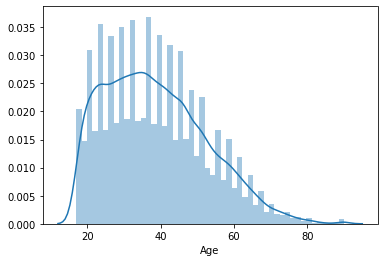

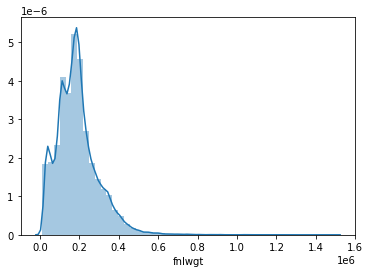

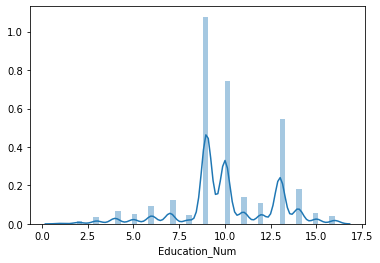

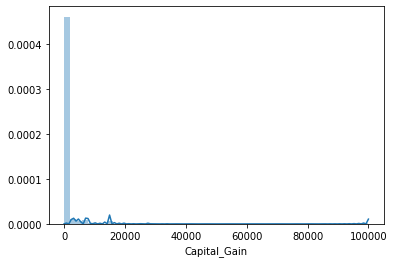

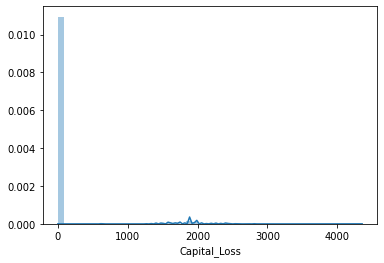

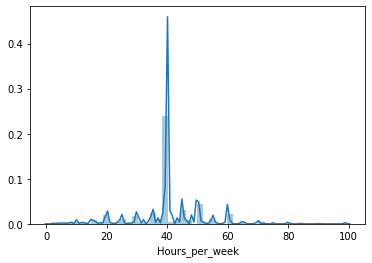

In [33]:
dist_plot(num_com)

<h3>Pair Plot</h3>

Note : Showing distribution of single variables and the relationship between two variables.

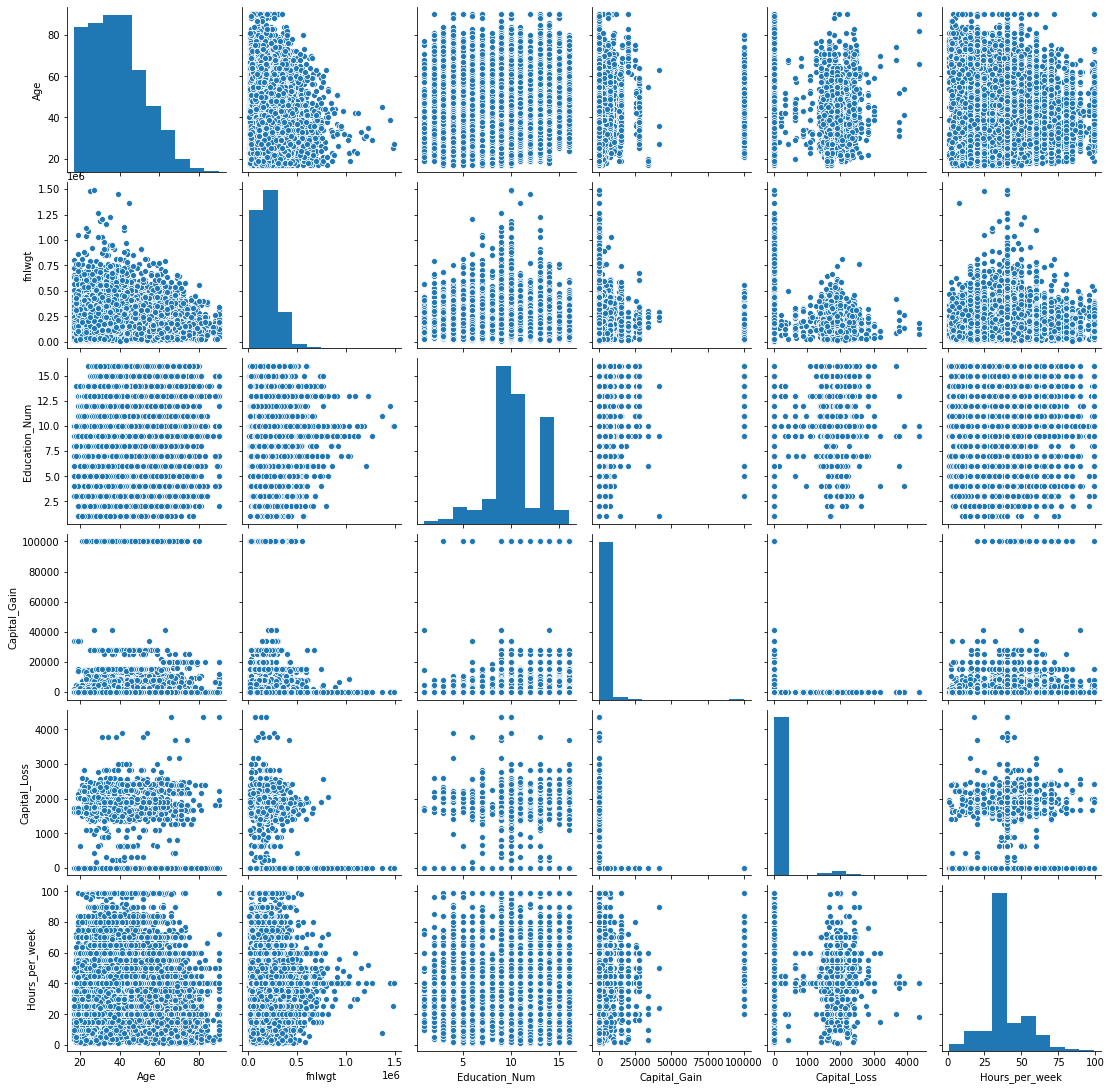

In [34]:
sns.pairplot(combined)

<h3>Numerical Variables Correlation using Pearson's</h3>

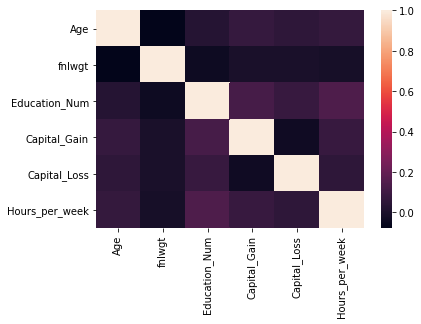

In [35]:
# numerical variables are not correlated
sns.heatmap(combined.corr())

<h3>Categorical Correlation using Cramers V</h3>

Note : 

  * Education, Marital Status, Relationship and Occupation have moderate correlation with Target 
  * Sex and Relationship has high correlation ( > 0.5)

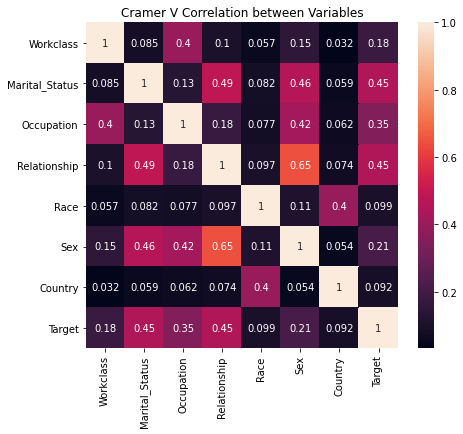

In [36]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


cols = ['Workclass', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
corrM = np.ones((len(cols),len(cols)))
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(combined[col1], combined[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");


<h3> Encoding All Categorical Columns</h3>

In [0]:
combined_2 = combined.copy()

<h4>Encoded Target and Source columns</h4>

<h4>Source Column</h4>

* Label encoding  where train is 0 and test set is 1

In [38]:
combined_2['source'].value_counts()

train    32561
test     16281
Name: source, dtype: int64

In [0]:
combined_2['source'] = np.where(combined_2['source'] == 'train', 0, 1)

In [40]:
# 0 is train set and 1 is test set
combined_2['source'].value_counts()

0    32561
1    16281
Name: source, dtype: int64

<h4> Target Column </h4>

  * Label encoding where <=50K is 0 and >50K is 1

In [41]:
combined_2['Target'].value_counts()

 <=50K    37155
 >50K     11687
Name: Target, dtype: int64

In [0]:
combined_2['Target'] = np.where(combined["Target"].str.contains("="), 0, 1)

In [43]:
combined_2['Target'].value_counts()

0    37155
1    11687
Name: Target, dtype: int64

<h4>Education </h4>

* Label encoding

In [0]:
#combined_2['Education'].value_counts()

In [0]:
#combined_2['Education'].astype('category').cat.categories.tolist()

In [0]:
#combined_2['Education'] = combined_2['Education'].map({' Preschool':1,' 1st-4th':2, ' 5th-6th':3, ' 7th-8th':4, ' 9th':5,' 10th':6, ' 11th':7, 
#                                       ' 12th':8,' HS-grad':9,' Some-college':10,' Assoc-acdm':12,' Assoc-voc':11,' Bachelors':13,
#                                       ' Masters':14,' Prof-school':15,' Doctorate':16})

In [0]:
#combined_2['Education'].value_counts(normalize=True)

In [0]:
#combined['Education'].value_counts(normalize=True)

In [0]:
#combined_2['Education_Num'].value_counts(normalize=True)

* Education and Education Num is the same so Education will be dropped.

In [0]:
combined_3 = combined_2.copy()
combined_3 = combined_3.drop('Education', axis=1)

In [51]:
#combined_3.head()
combined_3.shape

(48842, 15)

In [52]:
cat_cols = combined_3.select_dtypes(include='object').columns
cat_cols

Index(['Workclass', 'Marital_Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Country'],
      dtype='object')

<h4>Frequency Encoding </h4>

In [53]:
combined_3.describe(include=np.object)

,Workclass,Marital_Status,Occupation,Relationship,Race,Sex,Country
count,48842,48842,48842,48842,48842,48842,48842
unique,9,7,15,6,5,2,42
top,Private,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,33906,22379,6172,19716,41762,32650,43832


In [0]:
#combined['Marital_Status'].str.replace('-', '')

In [0]:
cols = ['Workclass','Marital_Status',	'Occupation','Relationship',	'Race',	'Sex',	'Country']
for col in cols:
  combined_3[col] = combined_3[col].str.replace('-', '')

In [0]:
#cross-check
#combined_3['Relationship'].value_counts()

In [0]:
cols = ['Occupation', 'Country', 'Workclass']

def freq_encoding(df, cols):
  for col in cols:
    enc_col = (df.groupby(col).size()) / len(df)
    df[col] = df[col].apply(lambda x : enc_col[x])
  return df


combined_3 = freq_encoding(combined_3, cols)

In [58]:
# Cross Check
# 89% of Country is United-States means the prediction results will be biased toward US standard salary
#combined['Country'].value_counts(normalize=True)
#combined_3['Occupation'].value_counts(normalize=True)
combined_3[['Occupation', 'Country', 'Workclass']].describe()

,Occupation,Country,Workclass
count,48842.000000,48842.000000,48842.000000
mean,0.096708,0.806231,0.499279
std,0.034773,0.269751,0.293845
min,0.000307,0.000020,0.000205
25%,0.061873,0.897424,0.079071
50%,0.112690,0.897424,0.694198
75%,0.125138,0.897424,0.694198
max,0.126367,0.897424,0.694198


<h4>OHE </h4>

In [0]:
def ohe_encoding(df, cols):
  df = pd.get_dummies(df, columns = cols,prefix_sep='_')
  return df

In [0]:
cols = ['Race', 'Sex', 'Marital_Status','Relationship']
combined_3 = ohe_encoding(combined_3, cols)

In [61]:
combined_3.shape

(48842, 31)

In [62]:
combined_3.head()

,Age,Workclass,fnlwgt,Education_Num,Occupation,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target,source,Race_ AmerIndianEskimo,Race_ AsianPacIslander,Race_ Black,Race_ Other,Race_ White,Sex_ Female,Sex_ Male,Marital_Status_ Divorced,Marital_Status_ MarriedAFspouse,Marital_Status_ Marriedcivspouse,Marital_Status_ Marriedspouseabsent,Marital_Status_ Nevermarried,Marital_Status_ Separated,Marital_Status_ Widowed,Relationship_ Husband,Relationship_ Notinfamily,Relationship_ Otherrelative,Relationship_ Ownchild,Relationship_ Unmarried,Relationship_ Wife
0,39,0.040559,77516,13,0.114881,2174,0,40,0.897424,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
1,50,0.079071,83311,13,0.124606,0,0,13,0.897424,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
2,38,0.694198,215646,9,0.042423,0,0,40,0.897424,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0
3,53,0.694198,234721,7,0.042423,0,0,40,0.897424,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
4,28,0.694198,338409,13,0.126367,0,0,40,0.002825,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [63]:
combined_3['Target'].value_counts(normalize=True)

0    0.760718
1    0.239282
Name: Target, dtype: float64

In [64]:
combined_3.columns

Index(['Age', 'Workclass', 'fnlwgt', 'Education_Num', 'Occupation',
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target',
       'source', 'Race_ AmerIndianEskimo', 'Race_ AsianPacIslander',
       'Race_ Black', 'Race_ Other', 'Race_ White', 'Sex_ Female', 'Sex_ Male',
       'Marital_Status_ Divorced', 'Marital_Status_ MarriedAFspouse',
       'Marital_Status_ Marriedcivspouse',
       'Marital_Status_ Marriedspouseabsent', 'Marital_Status_ Nevermarried',
       'Marital_Status_ Separated', 'Marital_Status_ Widowed',
       'Relationship_ Husband', 'Relationship_ Notinfamily',
       'Relationship_ Otherrelative', 'Relationship_ Ownchild',
       'Relationship_ Unmarried', 'Relationship_ Wife'],
      dtype='object')

In [0]:

combined_3.columns = combined_3.columns.str.replace(r'\s+', '')


In [66]:
combined_3.columns

Index(['Age', 'Workclass', 'fnlwgt', 'Education_Num', 'Occupation',
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target',
       'source', 'Race_AmerIndianEskimo', 'Race_AsianPacIslander',
       'Race_Black', 'Race_Other', 'Race_White', 'Sex_Female', 'Sex_Male',
       'Marital_Status_Divorced', 'Marital_Status_MarriedAFspouse',
       'Marital_Status_Marriedcivspouse', 'Marital_Status_Marriedspouseabsent',
       'Marital_Status_Nevermarried', 'Marital_Status_Separated',
       'Marital_Status_Widowed', 'Relationship_Husband',
       'Relationship_Notinfamily', 'Relationship_Otherrelative',
       'Relationship_Ownchild', 'Relationship_Unmarried', 'Relationship_Wife'],
      dtype='object')

In [67]:
#cross check
combined_3.describe()

,Age,Workclass,fnlwgt,Education_Num,Occupation,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target,source,Race_AmerIndianEskimo,Race_AsianPacIslander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male,Marital_Status_Divorced,Marital_Status_MarriedAFspouse,Marital_Status_Marriedcivspouse,Marital_Status_Marriedspouseabsent,Marital_Status_Nevermarried,Marital_Status_Separated,Marital_Status_Widowed,Relationship_Husband,Relationship_Notinfamily,Relationship_Otherrelative,Relationship_Ownchild,Relationship_Unmarried,Relationship_Wife
count,48842.000000,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,0.499279,1.896641e+05,10.078089,0.096708,1079.067626,87.502314,40.422382,0.806231,0.239282,0.333340,0.009623,0.031100,0.095922,0.008313,0.855043,0.331518,0.668482,0.135805,0.000758,0.458192,0.012858,0.329982,0.031325,0.031080,0.403669,0.257627,0.030834,0.155215,0.104930,0.047725
std,13.710510,0.293845,1.056040e+05,2.570973,0.034773,7452.019058,403.004552,12.391444,0.269751,0.426649,0.471412,0.097624,0.173591,0.294487,0.090794,0.352061,0.470764,0.470764,0.342585,0.027513,0.498254,0.112662,0.470211,0.174198,0.173535,0.490638,0.437332,0.172870,0.362113,0.306467,0.213187
min,17.000000,0.000205,1.228500e+04,1.000000,0.000307,0.000000,0.000000,1.000000,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.079071,1.175505e+05,9.000000,0.061873,0.000000,0.000000,40.000000,0.897424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.694198,1.781445e+05,10.000000,0.112690,0.000000,0.000000,40.000000,0.897424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,0.694198,2.376420e+05,12.000000,0.125138,0.000000,0.000000,45.000000,0.897424,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,90.000000,0.694198,1.490400e+06,16.000000,0.126367,99999.000000,4356.000000,99.000000,0.897424,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h3>Target Imbalance</h3>

In [68]:
neg, pos = np.bincount(combined_3['Target'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 48842
    Positive: 11687 (23.93% of total)



<h3>Forward Feature Selection</h3>

In [0]:
combined_4 = combined_3.copy()

In [0]:
# columns dropped: 'Country' and 'fnlwgt'
combined_4 = combined_4[['Age', 'Workclass', 'Education_Num', 'Occupation','Country',
       'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target',
       'source',  'Sex_Female', 'Sex_Male', 'Race_AmerIndianEskimo', 'Race_AsianPacIslander',
       'Race_Black', 'Race_Other', 'Race_White',
       'Marital_Status_Divorced', 'Marital_Status_MarriedAFspouse',
       'Marital_Status_Marriedcivspouse', 'Marital_Status_Marriedspouseabsent',
       'Marital_Status_Nevermarried', 'Marital_Status_Separated',
       'Marital_Status_Widowed', 'Relationship_Husband',
       'Relationship_Notinfamily', 'Relationship_Otherrelative',
       'Relationship_Ownchild', 'Relationship_Unmarried', 'Relationship_Wife']]

In [0]:
train_df = combined_4[combined_4['source'] == 0].copy()
test_df = combined_4[combined_4['source'] == 1].copy()

In [0]:
train_df = train_df.drop('source', axis = 1)
test_df = test_df.drop('source', axis = 1)

In [127]:
train_df.shape, test_df.shape

((32561, 29), (16281, 29))

In [0]:
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set


In [129]:
train_df['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

<h3> Split to Training, Validation, Testing </h3>

In [0]:
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Target'))

val_labels = np.array(val_df.pop('Target'))
test_labels = np.array(test_df.pop('Target'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

<h3> Standar Scaler </h3>


In [0]:
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)


In [132]:
# Cross check, mean = ~0 and std  = 1
train_features.shape,val_features.shape, test_features.shape

((26048, 28), (6513, 28), (16281, 28))

<h3>Modeling</h3> 

In [0]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(
          16, 
          activation='relu',
         #kernel_regularizer=tf.keras.regularizers.l1(0.1),
          input_shape=(train_features.shape[-1],)),
   tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=0.001),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [0]:
EPOCHS = 20
BATCH_SIZE = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [135]:
model = make_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                464       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [136]:
model.predict(train_features[:10])

array([[0.50651425],
       [0.58216757],
       [0.6552581 ],
       [0.31625253],
       [0.5596421 ],
       [0.3833813 ],
       [0.39016548],
       [0.3196643 ],
       [0.9086295 ],
       [0.4511147 ]], dtype=float32)

In [137]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7592


<h3>Set Initial Bias</h3>

In [138]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.15662124])

In [139]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.18958682],
       [0.2878818 ],
       [0.2690203 ],
       [0.19897595],
       [0.23412234],
       [0.11305586],
       [0.17485389],
       [0.27995455],
       [0.40450257],
       [0.05592277]], dtype=float32)

In [140]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6717


<h3>Initial Weights</h3>

In [0]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

<h3>Confirm that Fixed Bias Helps</h3>

In [0]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [0]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [0]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()


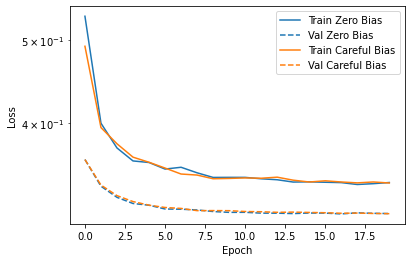

In [145]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

<h3>Train the Model</h3>

In [146]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/20
261/261 [==============================] - 1s 5ms/step - loss: 0.4987 - tp: 2781.0000 - fp: 1736.0000 - tn: 22984.0000 - fn: 5060.0000 - accuracy: 0.7913 - precision: 0.6157 - recall: 0.3547 - auc: 0.7854 - val_loss: 0.3609 - val_tp: 678.0000 - val_fp: 214.0000 - val_tn: 4749.0000 - val_fn: 872.0000 - val_accuracy: 0.8333 - val_precision: 0.7601 - val_recall: 0.4374 - val_auc: 0.8836
Epoch 2/20
261/261 [==============================] - 1s 2ms/step - loss: 0.3984 - tp: 2617.0000 - fp: 1213.0000 - tn: 18544.0000 - fn: 3674.0000 - accuracy: 0.8124 - precision: 0.6833 - recall: 0.4160 - auc: 0.8501 - val_loss: 0.3375 - val_tp: 780.0000 - val_fp: 262.0000 - val_tn: 4701.0000 - val_fn: 770.0000 - val_accuracy: 0.8415 - val_precision: 0.7486 - val_recall: 0.5032 - val_auc: 0.8965
Epoch 3/20
261/261 [==============================] - 1s 2ms/step - loss: 0.3735 - tp: 2761.0000 - fp: 1174.0000 - tn: 18583.0000 - fn: 3530.0000 - accuracy: 0.8194 - precision: 0.7017 - recall: 0.4389 - 

<h3>Plot History</h3>

In [0]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
   
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.tight_layout()


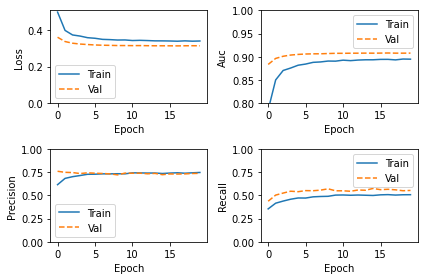

In [148]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

<h3>Confusion Matrix</h3>

In [0]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [0]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('The Salary <= 50K (True Negatives): ', cm[0][0])
  print('Lower 50K Salary Incorrectly Detected (False Positives): ', cm[0][1])
  print('Higher 50K Salary Incorrectly Detected (False Negatives): ', cm[1][0])
  print('The Salary > 50K (True Positives): ', cm[1][1])
  print('Total: ', np.sum(cm[1]))

loss :  0.3223046362400055
tp :  2096.0
fp :  704.0
tn :  11731.0
fn :  1750.0
accuracy :  0.8492721319198608
precision :  0.7485714554786682
recall :  0.5449817776679993
auc :  0.9017587900161743

The Salary <= 50K (True Negatives):  11731
Lower 50K Salary Incorrectly Detected (False Positives):  704
Higher 50K Salary Incorrectly Detected (False Negatives):  1750
The Salary > 50K (True Positives):  2096
Total:  3846


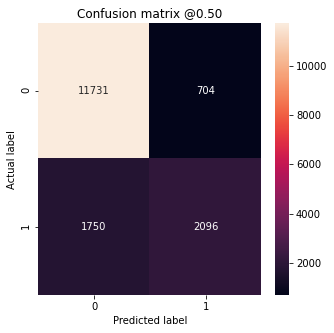

In [151]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

<h3>ROC</h3>

In [0]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

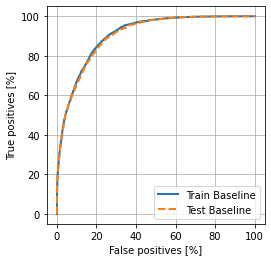

In [153]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')